In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.preprocessing import LabelEncoder
from networkx.algorithms import community
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.typing import SparseTensor

# Disease Gene Classification

Notes:
Use source and target ids instead of symbol as there are some issue which needs to be resolved based on duplicates.

## Load Node and Edge data

In [2]:
node_data = pd.read_csv('2024_05_05_meta_node_data.csv')
edge_data = pd.read_csv('2024_04_24_meta_edge_sourcetarget_disease_pub_pli_reciprocal.csv',low_memory=False)

## EDA for Duplicates

In [3]:
edge_data.head()

,source_target_key,source,source_symbol,target,target_symbol,interaction_cat,interaction_method,interaction_type,interaction_type_cat,interaction_source,interaction_count,all_mo_count,source_disease_assoc_cat,target_disease_assoc_cat,source_publication_count,target_publication_count,publication_count,source_pli,target_pli,reciprocal
0,7414;88,7414.0,VCL,88,ACTN2,physical,none,association,NaN,WormBase,1.0,"{'hsapien': 0, 'celegans': 1, 'mmusculus': 0, ...",disease_assoc,disease_assoc,279,150,429,0.9985,9.999600e-01,False
1,7414;1739,7414.0,VCL,1739,DLG1,physical,none,association,NaN,WormBase,1.0,"{'hsapien': 0, 'celegans': 1, 'mmusculus': 0, ...",disease_assoc,non_disease_assoc,279,282,561,0.9985,9.870900e-01,False
2,7414;1742,7414.0,VCL,1742,DLG4,physical,none,association,NaN,WormBase,1.0,"{'hsapien': 0, 'celegans': 1, 'mmusculus': 0, ...",disease_assoc,disease_assoc,279,251,530,0.9985,1.000000e+00,False
3,7414;1740,7414.0,VCL,1740,DLG2,physical,none,association,NaN,WormBase,1.0,"{'hsapien': 0, 'celegans': 1, 'mmusculus': 0, ...",disease_assoc,non_disease_assoc,279,95,374,0.9985,9.997500e-01,False
4,7414;7402,7414.0,VCL,7402,UTRN,physical,none,association,NaN,WormBase,1.0,"{'hsapien': 0, 'celegans': 1, 'mmusculus': 0, ...",disease_assoc,non_disease_assoc,279,167,446,0.9985,1.757100e-47,True


In [4]:
node_data.head()

,id,symbol,disease_assoc_cat,publication_count,ortholog_count,all_ortho_count
0,7414,VCL,disease_assoc,279,5,"{'hsapien': {'entrezid': 7414, 'symbol': 'VCL'..."
1,4626,MYH8,disease_assoc,36,4,"{'hsapien': {'entrezid': 4626, 'symbol': 'MYH8..."
2,9722,NOS1AP,disease_assoc,141,5,"{'hsapien': {'entrezid': 9722, 'symbol': 'NOS1..."
3,9891,NUAK1,non_disease_assoc,70,5,"{'hsapien': {'entrezid': 9891, 'symbol': 'NUAK..."
4,81788,NUAK2,disease_assoc,46,2,"{'hsapien': {'entrezid': 81788, 'symbol': 'NUA..."


In [5]:
node_data['symbol'].nunique()


19863

In [6]:
node_data['id'].nunique()

19867

In [7]:
duplicates = node_data[node_data.duplicated(subset=['symbol'], keep=False)]
duplicates

,id,symbol,disease_assoc_cat,publication_count,ortholog_count,all_ortho_count
1431,51072,MEMO1,non_disease_assoc,47,6,"{'hsapien': {'entrezid': 51072, 'symbol': 'MEM..."
3217,55016,1-Mar,non_disease_assoc,35,3,"{'hsapien': {'entrezid': 55016, 'symbol': 'MAR..."
4812,54996,2-Mar,non_disease_assoc,45,4,"{'hsapien': {'entrezid': 54996, 'symbol': 'MAR..."
4813,64757,1-Mar,non_disease_assoc,60,3,"{'hsapien': {'entrezid': 64757, 'symbol': 'MAR..."
13036,51257,2-Mar,non_disease_assoc,30,2,"{'hsapien': {'entrezid': 51257, 'symbol': 'MAR..."
17052,7795,MEMO1,non_disease_assoc,5,1,"{'hsapien': {'entrezid': 7795, 'symbol': 'MEMO..."
18020,6052,RNR1,non_disease_assoc,40,1,"{'hsapien': {'entrezid': 6052, 'symbol': 'RNR1..."
19456,4549,RNR1,non_disease_assoc,120,1,"{'hsapien': {'entrezid': 4549, 'symbol': 'RNR1..."


In [8]:
node_data['disease_assoc_cat'].unique()

array(['disease_assoc', 'non_disease_assoc', 'non_omim'], dtype=object)

In [9]:
edge_data['source_symbol'].nunique()

15638

In [10]:
edge_data['source_target_key'].nunique()

1685639

In [11]:
edge_data['source'].nunique()

15558

In [12]:
edge_data['target_symbol'].nunique()

19977

In [13]:
edge_data['target'].nunique()

19448

In [14]:
edge_data['reciprocal'].sum()

2314377

In [15]:
edge_data.shape

(3084697, 20)

## Create Adjacency matrix

In [152]:
G = nx.Graph()
# Add edges to the graph, considering the reciprocal column
for _, row in edge_data.iterrows():
    G.add_edge(row['source'], row['target'])
    if row['reciprocal']:
        G.add_edge(row['target'], row['source'])


In [307]:
edge_list = list(G.edges)
print(len(edge_list))
print(edge_list[10000])

1149728
(1253, 8196)


In [153]:
node_order = list(G.nodes())
node_order = [str(int(x)) for x in node_order]
print(type(node_order[0]))
# Create adjacency matrix
adj_matrix_directed = nx.to_numpy_array(G)
adj_directed_df = pd.DataFrame(adj_matrix_directed, index=node_order, columns=node_order)
adj_directed_df.head()


<class 'str'>


,7414,88,1739,1742,1740,7402,1756,26059,54514,1495,...,2831,2843,8387,5548,119764,27004,326343,221393,219557,152078
7414,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1739,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1742,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1740,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
adj_matrix_directed.shape

(19867, 19867)

In [156]:
adj_matrix_undirected = np.maximum(adj_matrix_directed, adj_matrix_directed.T)
adj_undirected_df = pd.DataFrame(adj_matrix_undirected, index=node_order, columns=node_order)
print(adj_undirected_df.index)
print(adj_undirected_df.columns)
adj_undirected_df.head()


Index(['7414', '88', '1739', '1742', '1740', '7402', '1756', '26059', '54514',
       '1495',
       ...
       '2831', '2843', '8387', '5548', '119764', '27004', '326343', '221393',
       '219557', '152078'],
      dtype='object', length=19867)
Index(['7414', '88', '1739', '1742', '1740', '7402', '1756', '26059', '54514',
       '1495',
       ...
       '2831', '2843', '8387', '5548', '119764', '27004', '326343', '221393',
       '219557', '152078'],
      dtype='object', length=19867)


,7414,88,1739,1742,1740,7402,1756,26059,54514,1495,...,2831,2843,8387,5548,119764,27004,326343,221393,219557,152078
7414,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1739,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1742,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1740,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [313]:
adj_matrix = adj_undirected_df.values

# Create the graph from the adjacency matrix
G = nx.from_numpy_array(adj_matrix)

# Relabel the nodes to match the original node labels
mapping = {i: node_order[i] for i in range(len(node_order))}
G = nx.relabel_nodes(G, mapping)

# Print the edges of the graph
print(len(list(G.edges(data=True))))


1149728


In [129]:
adj_undirected_df.to_csv('adj_mat_undirected.csv')
adj_directed_df.to_csv('adj_mat_directed.csv')

## Approaches

In [16]:
adj_undirected_df = pd.read_csv('adj_mat_undirected.csv', index_col=0)
adj_undirected_df.head()

### Label Propagation Basic Community detection

Cordasco, G., & Gargano, L. (2010, December). Community detection via semi-synchronous label propagation algorithms. In Business Applications of Social Network Analysis (BASNA), 2010 IEEE International Workshop on (pp. 1-8). IEEE.

In [275]:
def encode_labels(edge_data, initial_label, adj_undirected_df):
    """
    Encode node labels using LabelEncoder.

    Parameters:
    - edge_data: DataFrame containing 'source' and 'target' columns.

    Returns:
    - G: NetworkX graph with nodes encoded as integers.
    - lst_sampled_nodes: list of sampled nodes for this simulation run
    """

    adj_undirected_df.index = adj_undirected_df.index.astype(str)
    lst_sampled_nodes = list(initial_label.keys())
    lst_sampled_nodes = [ str(x) for x in lst_sampled_nodes]
    subset_adj_mat  = adj_undirected_df.loc[lst_sampled_nodes,lst_sampled_nodes].copy()

    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(subset_adj_mat.values)

    return G, lst_sampled_nodes


In [276]:
def sample_initial_labels(node_data, n_samples_disease, n_samples_nondisease, n_samples_nonomim):
    """
    Sample initial labels for nodes from node_data DataFrame.

    Parameters:
    - node_data: DataFrame with columns 'node_id' and 'label'.
    - n_samples_disease: Number of nodes to sample from disease class (label 0).
    - n_samples_nondisease: Number of nodes to sample from non-disease class (label 1).
    - n_samples_nonomim: Number of nodes to sample from non-omim class (label 2).

    Returns:
    - initial_labels: Dictionary mapping node_id to label.
    """
    initial_labels = {}

    # Sample nodes from each class
    disease_nodes = node_data[node_data['disease_assoc_cat'] == 'disease_assoc']['id'].sample(n=n_samples_disease, replace=False)
    nondisease_nodes = node_data[node_data['disease_assoc_cat'] == 'non_disease_assoc']['id'].sample(n=n_samples_nondisease, replace=False)
    nonomim_nodes = node_data[node_data['disease_assoc_cat'] == 'non_omim']['id'].sample(n=n_samples_nonomim, replace=False)

    # Assign labels
    for node_id in disease_nodes:
        initial_labels[node_id] = 'disease_assoc'
    for node_id in nondisease_nodes:
        initial_labels[node_id] = 'non_disease_assoc'
    for node_id in nonomim_nodes:
        initial_labels[node_id] = 'non_omim'

    return initial_labels



In [277]:
def apply_label_propagation(G):
    """
    Apply label propagation algorithm on the graph.

    Parameters:
    - G: NetworkX graph.
    - initial_labels: Dictionary mapping node_id to initial label.

    Returns:
    - labels: Final labels assigned to nodes after propagation.
    """
    # Assign initial labels to nodes
    #nx.set_node_attributes(G, initial_labels, 'label')
    labels = community.label_propagation_communities(G)

    return labels





In [278]:
def evaluate_performance(labels, true_labels):
    """
    Evaluate performance metrics.

    Parameters:
    - labels: Predicted labels from label propagation.
    - true_labels: True labels of nodes.

    Returns:
    - f1_score_value: Weighted F1 score.
    - confusion_mat: Confusion matrix.
    - fpr, tpr, roc_auc: ROC curve metrics.
    """
    # Calculate F1 score
    f1_score_value = f1_score(true_labels, labels, average='weighted')

    # Calculate confusion matrix
    confusion_mat = confusion_matrix(true_labels, labels)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(true_labels, labels)
    roc_auc = auc(fpr, tpr)

    return f1_score_value, confusion_mat, fpr, tpr, roc_auc



In [279]:
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

def calculate_majority_class(node_set, original_dict):
    # Count the occurrence of each class in the set
    class_counts = Counter(original_dict[node] for node in node_set)
    # Determine the majority class
    majority_class = class_counts.most_common(1)[0][0]
    return majority_class

def create_new_dictionary(set_list, original_dict):
    new_dict = {}
    for node_set in set_list:
        # Determine the majority class for the current set
        majority_class = calculate_majority_class(node_set, original_dict)
        # Assign the majority class to all nodes in the set
        for node in node_set:
            new_dict[node] = majority_class
    return new_dict

def calculate_accuracy(original_dict, new_dict):
    total = len(original_dict)
    correct = sum(1 for key in original_dict if original_dict[key] == new_dict.get(key))
    accuracy = correct / total
    return accuracy

def evaluate_performance(original_dict, new_dict):
    y_true = [original_dict[key] for key in original_dict]
    y_pred = [new_dict.get(key, -1) for key in original_dict]  # Using -1 for missing keys in new_dict

    # Calculate accuracy
    accuracy = calculate_accuracy(original_dict, new_dict)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=['disease_assoc', 'non_disease_assoc', 'non_omim'])

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, conf_matrix, f1

In [282]:
def simulate_runs(node_data, adj_undirected_df, edge_data, n_runs, n_samples):
    """
    Simulate multiple runs of sampling and label propagation.

    Parameters:
    - node_data: DataFrame with columns 'node_id' and 'label'.
    - edge_data: DataFrame with columns 'source' and 'target'.
    - n_runs: Number of simulation runs.
    - n_samples_disease: Number of nodes to sample from disease class (label 0).
    - n_samples_nondisease: Number of nodes to sample from non-disease class (label 1).
    - n_samples_nonomim: Number of nodes to sample from non-omim class (label 2).

    Returns:
    - sim_accuracy: final accuracy score over simulation runs.
    - sim_conf_matrix: confusion matrix over simulation runs.
    - sim_f1: final F1 score over simulation runs.
    """

    n_samples_disease = int(n_samples * 0.25)
    n_samples_nondisease = int(n_samples * 0.55)
    n_samples_nonomim = int(n_samples * 0.2)
    all_nodes = node_data['id']
    runs = {key : [] for key in all_nodes}
    sim_nodes = {}
    for _ in range(n_runs):
        converted_communities=[]
        # Sample initial labels
        initial_labels = sample_initial_labels(node_data, n_samples_disease, n_samples_nondisease, n_samples_nonomim)
        for key, value in initial_labels.items():
            if key not in sim_nodes:
                sim_nodes[key] = value
        # Encode labels and create graph
        G, lst_sampled_nodes = encode_labels(edge_data , initial_labels, adj_undirected_df)
        #decoded_labels = {node: le.inverse_transform([node])[0] for node in list(G.nodes())}
        # Apply label propagation algorithm
        labels = apply_label_propagation(G)
        for community in labels:
            comm = set()
            for node in community:
                comm.add(int(lst_sampled_nodes[node]))
            converted_communities.append(comm)
        # Evaluate performance
        pred_labels = create_new_dictionary(converted_communities, initial_labels)
        for key,value in pred_labels.items():
            runs[key].append(value)
        accuracy, conf_matrix, f1 = evaluate_performance(initial_labels, pred_labels)
        #print("Accuracy:", accuracy)
        #print("Confusion Matrix:\n", conf_matrix)
        #print("F1 Score:", f1)
    
    probability_dict = {}
    highest_prob_dict = {}

    # Calculate probabilities and highest probability entry for each node
    for node, entries in runs.items():
        count = Counter(entries)  # Count occurrences of each entry
        total = len(entries)  # Total number of entries for the node
        if(total>0):
            # Calculate probabilities
            probabilities = {entry: count[entry] / total for entry in count}
            probability_dict[node] = probabilities

            # Find the entry with the highest probability
            highest_prob_entry = max(probabilities, key=probabilities.get)
            highest_prob_dict[node] = highest_prob_entry

    # Calculate average performance metrics over runs
    sim_accuracy, sim_conf_matrix, sim_f1 = evaluate_performance(sim_nodes, highest_prob_dict)
    print("Final Accuracy:", sim_accuracy)
    print("Final Confusion Matrix:\n", sim_conf_matrix)
    print("Final F1 Score:", sim_f1) 

    return sim_accuracy,sim_conf_matrix,sim_f1



Running simulation with n_runs=500 and n_samples=500
Final Accuracy: 0.8380731866914984
Final Confusion Matrix:
 [[ 2099  2697     0]
 [    0 11423     1]
 [    0   519  3128]]
Final F1 Score: 0.8205099193128077
Running simulation with n_runs=500 and n_samples=1000
Final Accuracy: 0.7618160769114612
Final Confusion Matrix:
 [[ 1064  3732     0]
 [    0 11424     0]
 [    0  1000  2647]]
Final F1 Score: 0.7184336599701046
Running simulation with n_runs=500 and n_samples=5000
Final Accuracy: 0.6543514370564252
Final Confusion Matrix:
 [[  146  4650     0]
 [    0 11424     0]
 [    0  2217  1430]]
Final F1 Score: 0.5598120073199312
Running simulation with n_runs=500 and n_samples=10000
Final Accuracy: 0.5988825690844113
Final Confusion Matrix:
 [[   26  4770     0]
 [    0 11423     1]
 [    0  3198   449]]
Final F1 Score: 0.46915743326282794
Running simulation with n_runs=1000 and n_samples=500
Final Accuracy: 0.8369154879951679
Final Confusion Matrix:
 [[ 2064  2732     0]
 [    0 1142

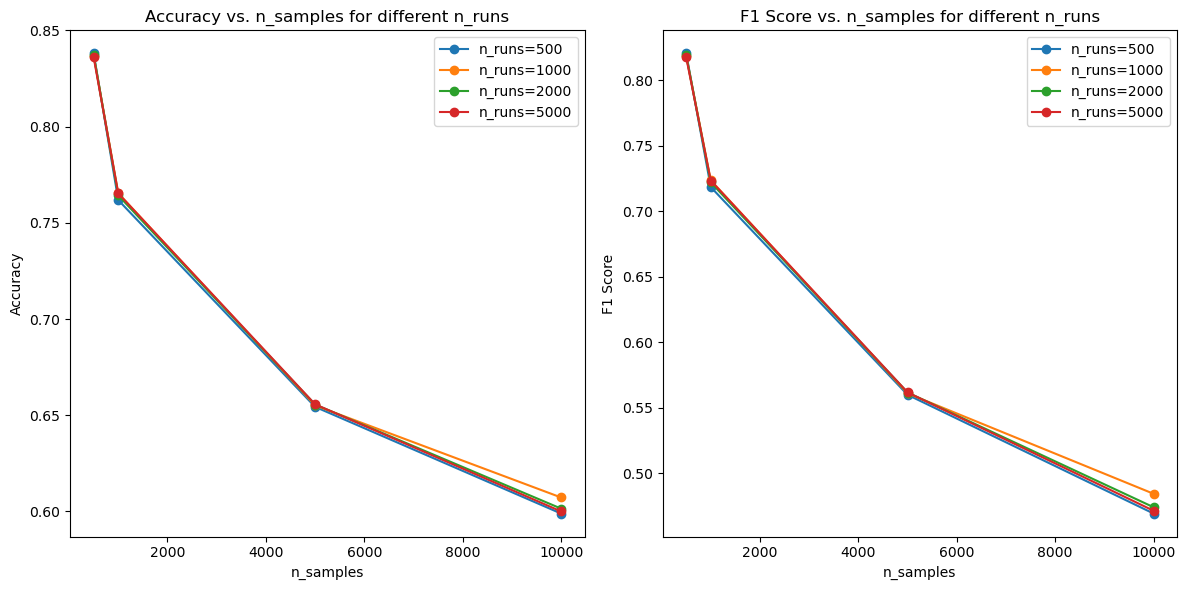

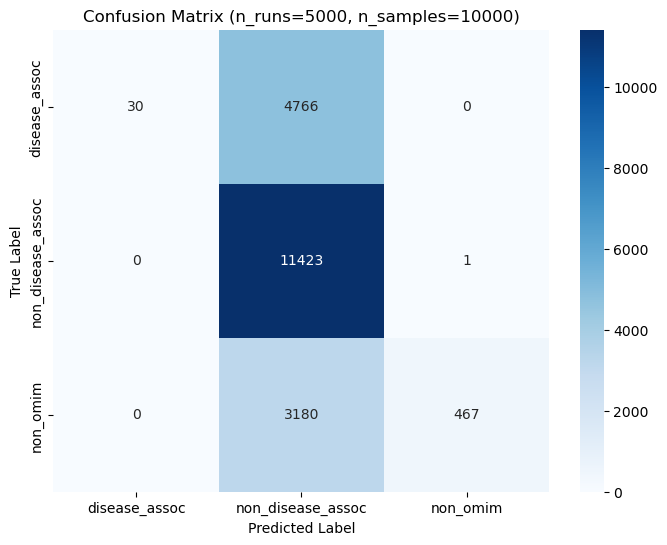

Simulation complete.


In [283]:

# Define the ranges for n_runs and n_samples
n_runs_list = [500, 1000, 2000, 5000]
n_samples_list = [500, 1000, 5000, 10000]

results = {
    'n_runs': [],
    'n_samples': [],
    'accuracy': [],
    'f1_score': [],
    'conf_matrix': []
}

for n_runs in n_runs_list:
    for n_samples in n_samples_list:
        print(f"Running simulation with n_runs={n_runs} and n_samples={n_samples}")
        accuracy, conf_matrix, f1 = simulate_runs(node_data, adj_undirected_df, edge_data, n_runs, n_samples)
        results['n_runs'].append(n_runs)
        results['n_samples'].append(n_samples)
        results['accuracy'].append(accuracy)
        results['f1_score'].append(f1)
        results['conf_matrix'].append(conf_matrix)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
for n_runs in n_runs_list:
    accuracies = [results['accuracy'][i] for i in range(len(results['n_runs'])) if results['n_runs'][i] == n_runs]
    plt.plot(n_samples_list, accuracies, marker='o', label=f'n_runs={n_runs}')
plt.xlabel('n_samples')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. n_samples for different n_runs')
plt.legend()

# Plot F1 score
plt.subplot(1, 2, 2)
for n_runs in n_runs_list:
    f1_scores = [results['f1_score'][i] for i in range(len(results['n_runs'])) if results['n_runs'][i] == n_runs]
    plt.plot(n_samples_list, f1_scores, marker='o', label=f'n_runs={n_runs}')
plt.xlabel('n_samples')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. n_samples for different n_runs')
plt.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrices for the last configuration of n_runs and n_samples
labels = ['disease_assoc', 'non_disease_assoc', 'non_omim']
for i in range(len(results['conf_matrix'])):
    if results['n_runs'][i] == n_runs_list[-1] and results['n_samples'][i] == n_samples_list[-1]:
        plt.figure(figsize=(8, 6))
        sns.heatmap(results['conf_matrix'][i], annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title(f'Confusion Matrix (n_runs={n_runs_list[-1]}, n_samples={n_samples_list[-1]})')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

print("Simulation complete.")

## Label Propagation with Pytorch Implementation of Label propagation
The label propagation operator, firstly introduced in the “Learning from Labeled and Unlabeled Data with Label Propagation” paper.

where unlabeled data is inferred by labeled data via propagation. This concrete implementation here is derived from the “Combining Label Propagation And Simple Models Out-performs Graph Neural Networks” paper.

In this implementation we are dropping non-omim nodes and of the remaining nodes which are disease and non-disease nodes are now split into 80 train and 20 test (here train and test is for finding/learning the approproate alpha and num_layers (int) – The number of propagations.). Iterate over various possible iterations for both the parameters to find the best values for them.

In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import LabelPropagation
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter the DataFrame
def filter_nodes(df):
    return df[df['disease_assoc_cat'] != 'non_omim']

# Step 2: Construct Graph Structure
def construct_graph(edge_index, node_features=None, labels=None):
    if node_features is not None:
        data = Data(x=node_features, edge_index=edge_index, y=labels)
    else:
        data = Data(edge_index=edge_index, y=labels)
        #data.num_nodes = 16220
    return data

# Step 3: Split Data
def split_data(data, train_size=0.8):
    indices = np.arange(data.num_nodes)
    train_indices, val_indices = train_test_split(indices, train_size=train_size, random_state=42)
    return train_indices, val_indices

# Step 4: Model Training and Evaluation
def train_label_propagation(data, train_indices, val_indices, num_layers, alpha, loss_fn):
    model = LabelPropagation(num_layers=num_layers, alpha=alpha)
    
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    
    data.train_mask[train_indices] = True
    data.val_mask[val_indices] = True

    model.eval()
    print(data.y.size(0))
    out = model(edge_index=data.edge_index, y=data.y)  # Use edge_index and initial labels (data.y)
    train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    val_loss = loss_fn(out[data.val_mask], data.y[data.val_mask])

    print(f'Num Layers: {num_layers}, Alpha: {alpha}, Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}')

    return train_loss.item(), val_loss.item()

# Step 5: Plot Results
def plot_loss(results):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x="alpha", y="val_loss", hue="num_layers", data=results)
    plt.title("Validation Loss vs Alpha for Different num_layers")
    plt.xlabel("Alpha")
    plt.ylabel("Validation Loss")
    plt.show()

# Main function to run the simulation
def run_simulation(df, edge_index, labels, alphas, num_layers_list, loss_fn=F.cross_entropy):
    results = []

    data = construct_graph(edge_index, labels=labels)
    print(type(data.y))
    print(data.y.dtype)
    for alpha in alphas:
        for num_layers in num_layers_list:
            train_indices, val_indices = split_data(data)
            train_loss, val_loss = train_label_propagation(data, train_indices, val_indices, num_layers, alpha, loss_fn)
            results.append({
                "alpha": alpha,
                "num_layers": num_layers,
                "train_loss": train_loss,
                "val_loss": val_loss
            })
    
    results_df = pd.DataFrame(results)
    plot_loss(results_df)




In [18]:
node_data['encoded_id'] = pd.factorize(node_data['id'])[0]


edge_data = edge_data.merge(node_data[['id', 'encoded_id']], left_on='source', right_on='id', how='left')
edge_data = edge_data.rename(columns={'encoded_id': 'source_encoded_id'}).drop(columns='id')

# Merge the target encoded id
edge_data = edge_data.merge(node_data[['id', 'encoded_id']], left_on='target', right_on='id', how='left')
edge_data = edge_data.rename(columns={'encoded_id': 'target_encoded_id'}).drop(columns='id')

# Create an undirected graph
G = nx.Graph()

# Add edges to the graph
for _, row in edge_data.iterrows():
    G.add_edge(row['source_encoded_id'], row['target_encoded_id'])

# Extract the edge index
edge_index = list(G.edges)

# # Separate the source and target nodes
# src_nodes = edge_data['source'].astype(int)
# tgt_nodes = edge_data['target'].astype(int)

# undirected_edges = []
# for src, tgt in zip(src_nodes.values, tgt_nodes.values):
#     undirected_edges.append((src, tgt))
#     undirected_edges.append((tgt, src))

# undirected_edges = list(set(undirected_edges))
# src_nodes = [edge[0] for edge in undirected_edges]
# tgt_nodes = [edge[1] for edge in undirected_edges]
# final = [src_nodes, tgt_nodes]
# print(len(undirected_edges))
# # Convert to a torch tensor
# edge_index = torch.tensor(final, dtype=torch.long)
# print(type(edge_index))
# print(edge_index.shape)

# adj_ = adj_undirected_df.values
# print(type(adj_))

# # Step 2: Convert the dense adjacency matrix to edge indices and edge weights
# row, col = np.nonzero(adj_)  # Get the row and column indices of non-zero elements
# edge_index = np.vstack((row, col))  # Stack the row and column indices
# edge_weight = adj_[row, col]  # Get the edge weights

# # Convert to PyTorch tensors
# edge_index = torch.tensor(edge_index, dtype=torch.long)
# edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# # Step 3: Create the SparseTensor directly
# sparse_tensor = SparseTensor(row=edge_index[0], col=edge_index[1], value=edge_weight)


In [19]:
print(len(edge_index))
print(edge_index[0])

1149728
(0, 3614)


In [20]:
# Separate the source and target nodes
src_nodes = [t[0] for t in edge_index]
tgt_nodes = [t[0] for t in edge_index]
final = [src_nodes, tgt_nodes]

# Convert to a torch tensor
edge_index_tensor = torch.tensor(final, dtype=torch.long)

In [22]:
edge_index_tensor.shape

torch.Size([2, 1149728])

In [21]:
# Example usage:
# Assume df is your DataFrame with 'node_id' and 'class', edge_index is your edge list and labels are your labels
filtered_node_data = filter_nodes(node_data)
df = filtered_node_data[['id','disease_assoc_cat']]
labels = df['disease_assoc_cat'].values
alphas = np.linspace(0, 1, 10)
num_layers_list = [2, 3, 4, 5]
label_mapping = {
    'disease_assoc': 0,
    'non_disease_assoc': 1,
    'non_omim': 2
}

# Function to encode labels
def encode_labels(labels, mapping):
    encoded_labels = [mapping[label] for label in labels]
    return encoded_labels

# Encode the labels
encoded_labels = encode_labels(labels, label_mapping)
labels = torch.tensor(encoded_labels)
run_simulation(df, edge_index_tensor, labels, alphas, num_layers_list)

<class 'torch.Tensor'>
torch.int64
16220


/Users/rishabh_raj/anaconda3/envs/brain/lib/python3.11/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
/Users/rishabh_raj/anaconda3/envs/brain/lib/python3.11/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'train_mask', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


RuntimeError: index 16220 is out of bounds for dimension 0 with size 16220